# Notebook that demonstrates the use of the UF23 model

In [1]:
# to import the gmf.py, this cell should be only executed once after kernel restart
%cd ..
%cd ..

/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs/notebooks
/mnt/c/Users/friba/Desktop/Bachelorarbeit/gammaALPs


/home/flandgraf/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from gammaALPs.bfields import gmf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

fatal: No names found, cannot describe anything.


## Build coordinate arrays

In [3]:
x = np.arange(-20., 20.1, 0.1)
y = np.arange(-20., 20.1, 0.1)
z = np.arange(-10., 10.02, 0.02)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

In [4]:
rr = np.sqrt(np.power(xx, 2) + np.power(yy, 2))
pp = np.arctan2(yy, xx)

In [5]:
print(rr.shape)

(401, 401, 1001)


## Initialize GMF model

Initialze the UF23 class with one of 8 models (see https://arxiv.org/abs/2311.12120)

In [6]:
models = ['base', 'expX', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', 'spur']
model = 'base'

In [7]:
uf23 = gmf.UF23(model=model)

In [8]:
spur = gmf.UF23(model='spur')

## Disk component

In [9]:
zplot = 0
idz = np.absolute(z-zplot).argmin()
print(idz)

500


In [10]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = uf23.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

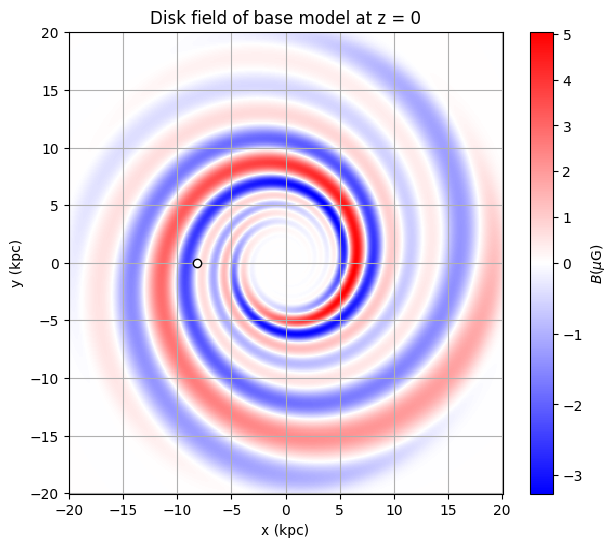

In [13]:
plt.figure(figsize=(7,6))

norm = TwoSlopeNorm(vmin=Bdisk.min(), vcenter=0, vmax=Bdisk.max())
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, norm=norm, cmap = plt.cm.bwr, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.title(f"Disk field of {model} model at z = {zplot}")

plt.plot(-8.2, 0., marker='o', mec='k', mfc='w')
plt.grid()

#plt.savefig("notebooks/UF23/base_spiral_field.png")
plt.show()

#### For the spur model:

In [14]:
Bdisk_spur = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = spur.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk_spur[:,i] = b[1] * gmf.signum(b[0][1,:])

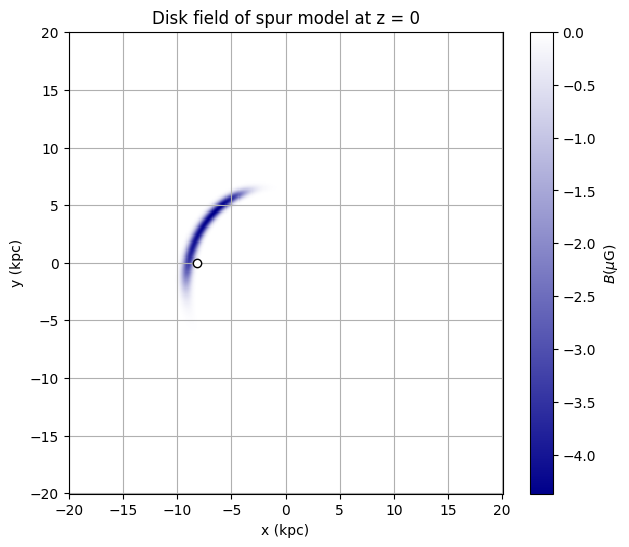

In [16]:
plt.figure(figsize=(7,6))
cmap0 = LinearSegmentedColormap.from_list('', ['darkblue', 'white'])

p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk_spur, cmap = cmap0, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.title(f"Disk field of spur model at z = {zplot}")

plt.plot(-8.2, 0., marker='o', mec='k', mfc='w')
plt.grid()

#plt.savefig("notebooks/UF23/spur_spiral_field.png")
plt.show()

## Toroidal halo component

Only phi component

In [17]:
yplot = 0
idy = np.absolute(y-yplot).argmin()
print(idy)

200


In [18]:
Bhalo_tor = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = uf23.toroidal_halo_field(rho=np.sqrt(xi**2. + y[idy]**2.), z=zz[i,idy,:]) 
    Bhalo_tor[i,:] = b[1] * gmf.signum(b[0][1,:])

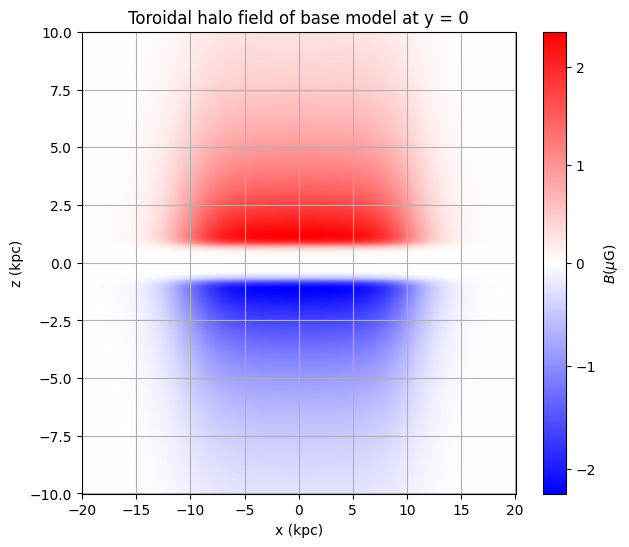

In [20]:
plt.figure(figsize=(7,6))

norm = TwoSlopeNorm(vmin=Bhalo_tor.min(), vcenter=0, vmax=Bhalo_tor.max())
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo_tor, norm=norm, cmap = plt.cm.bwr, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.title(f"Toroidal halo field of {model} model at y = {yplot}")

plt.grid()

#plt.savefig("notebooks/UF23/base_toroidal_field.png")
plt.show()

## Poloidal halo component

Only r and z component

In [21]:
yplot = 0
idy = np.absolute(y-yplot).argmin()
print(idy)

200


In [22]:
BX = np.zeros([3] + list(xx[:,idy,:].shape))
BX_abs = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = uf23.poloidal_halo_field(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]

In [23]:
# convert to cartesian coordinates, phi component is zero
BX_x = BX[0] * np.cos(pp[:,idy,...])
BX_y = BX[0] * np.sin(pp[:,idy,...])

BX_z = BX[2]
BX_abss = np.where(BX_abs == 0, 1e-24, BX_abs)

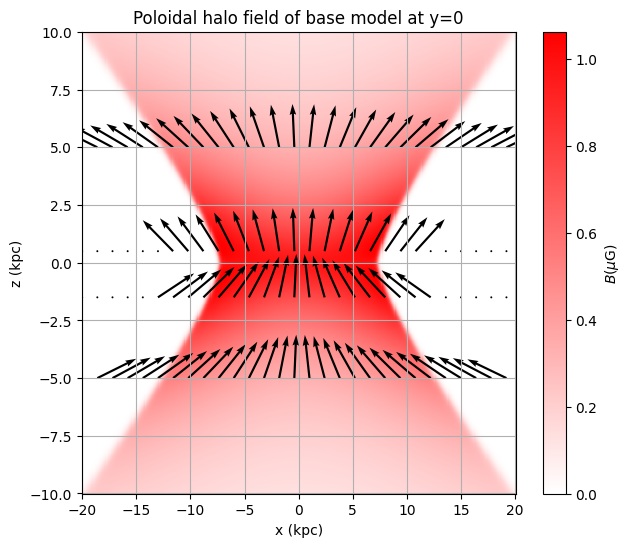

In [26]:
cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])
plt.figure(figsize=(7,6))

p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX_abs, cmap=cmap0, shading='auto')

plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

z0 = 0.5
idz = np.absolute(z-z0).argmin()
# print(idz, z[idz])
step = 14
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = -1.5
idz = np.absolute(z-z0).argmin()
# print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = -5
idz = np.absolute(z-z0).argmin()
# print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = 5
idz = np.absolute(z-z0).argmin()
# print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )
# plt.streamplot(xx[:,idy,:], zz[:,idy,:], BX_x, BX_z, broken_streamlines=False, density=0.35)

plt.title(f'Poloidal halo field of {model} model at y={yplot}')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

#plt.savefig("notebooks/UF23/base_poloidal_field.png")
plt.show()

## Twisted halo field

In [21]:
twistx = gmf.UF23(model="twistX")